# Scaling Law Analysis: WandB Experiments vs Theory

This notebook pulls training data from our WandB experiments and compares against:
1. **OpenAI Dense Scaling Law**: $L(C) = (C_c^{min}/C)^{\alpha_C^{min}}$
2. **Apple MoE Scaling Law**: $L(N, D, S) = \frac{a}{N^\alpha} + \frac{b}{D^\beta} + \frac{c}{(1-S)^\lambda} + \frac{d}{(1-S)^\delta N^\gamma} + e$

## Goals
- Compare our dense model training runs against scaling law predictions
- Compare our MoE model training runs against scaling law predictions  
- Quantify how much more efficient MoE is vs dense in our experiments
- Identify any deviations from predicted scaling behavior

In [1]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# Plotting setup
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# WandB API setup
WANDB_API_KEY = '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'
PROJECT = 'timurichk-university-of-waterloo/OLMo-core-src_scripts_relace'

wandb.login(key=WANDB_API_KEY)
api = wandb.Api()
print('Connected to WandB!')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/timur/.netrc
wandb: Currently logged in as: timurichk (timurichk-university-of-waterloo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Connected to WandB!


## 1. Define Scaling Law Functions

First, let's define the scaling laws from the OpenAI and Apple papers.

In [2]:
@dataclass
class OpenAIScalingCoeffs:
    """OpenAI scaling law coefficients (Equation 1.3)."""
    alpha_C_min: float = 0.050  # Compute scaling exponent
    C_c_min: float = 3.1e8     # Critical compute in PF-days

@dataclass 
class AppleMoECoeffs:
    """Apple MoE scaling law coefficients (Equation 6, Table 3)."""
    # Exponents
    alpha: float = 0.5962   # N (total params) exponent
    beta: float = 0.3954    # D (data) exponent  
    lambd: float = -0.1666  # (1-S) exponent (negative = sparsity helps!)
    delta: float = 0.1603   # (1-S) in interaction term
    gamma: float = 0.1595   # N in interaction term
    
    # Scaling constants
    a: float = 16612.50     # N term coefficient
    b: float = 5455.67      # D term coefficient
    c: float = 0.4598       # Sparsity term coefficient
    d: float = 17.26        # Interaction term coefficient
    e: float = 0.94         # Irreducible loss

openai_coeffs = OpenAIScalingCoeffs()
apple_coeffs = AppleMoECoeffs()

def openai_loss_from_compute(C_pf_days: float) -> float:
    """OpenAI scaling law: L(C) = (C_c^min / C)^alpha"""
    return (openai_coeffs.C_c_min / C_pf_days) ** openai_coeffs.alpha_C_min

def apple_moe_loss(N: float, D: float, S: float) -> float:
    """
    Apple MoE scaling law (Equation 6).
    
    L(N, D, S) = a/N^α + b/D^β + c/(1-S)^λ + d/((1-S)^δ * N^γ) + e
    
    Args:
        N: Total (non-embedding) parameters
        D: Dataset size in tokens
        S: Sparsity ratio = 1 - (active_params / total_params)
    """
    S = np.clip(S, 0, 0.9999)
    one_minus_S = 1 - S
    
    term_N = apple_coeffs.a / (N ** apple_coeffs.alpha)
    term_D = apple_coeffs.b / (D ** apple_coeffs.beta)
    term_S = apple_coeffs.c / (one_minus_S ** apple_coeffs.lambd)
    term_interact = apple_coeffs.d / ((one_minus_S ** apple_coeffs.delta) * (N ** apple_coeffs.gamma))
    
    return term_N + term_D + term_S + term_interact + apple_coeffs.e

def apple_dense_loss(N: float, D: float) -> float:
    """Apple scaling law for dense models (S=0)."""
    return apple_moe_loss(N, D, S=0.0)

# Unit conversions
def pf_to_flops(pf: float) -> float:
    """PetaFLOPs to FLOPs"""
    return pf * 1e15

def flops_to_pf(flops: float) -> float:
    """FLOPs to PetaFLOPs"""
    return flops / 1e15

def pf_days_to_flops(pf_days: float) -> float:
    """PF-days to FLOPs"""
    return pf_days * 1e15 * 86400

def flops_to_pf_days(flops: float) -> float:
    """FLOPs to PF-days"""
    return flops / (1e15 * 86400)

print("Scaling law functions defined!")
print(f"\nApple MoE Coefficients:")
for k, v in apple_coeffs.__dict__.items():
    print(f"  {k}: {v}")

Scaling law functions defined!

Apple MoE Coefficients:
  alpha: 0.5962
  beta: 0.3954
  lambd: -0.1666
  delta: 0.1603
  gamma: 0.1595
  a: 16612.5
  b: 5455.67
  c: 0.4598
  d: 17.26
  e: 0.94


## 2. Pull Data from WandB

Now let's pull all the training runs and extract the key metrics.

In [3]:
def extract_moe_params(config: dict) -> Tuple[Optional[int], Optional[int], Optional[float]]:
    """
    Extract MoE parameters from config.
    
    Returns:
        (num_experts, top_k, active_params) or (None, None, None) if not MoE
    """
    try:
        model = config.get('model', {})
        block = model.get('block', {})
        moe_config = block.get('feed_forward_moe')
        
        if moe_config is None:
            return None, None, None
        
        num_experts = moe_config.get('num_experts')
        top_k = moe_config.get('router', {}).get('top_k')
        hidden_size = moe_config.get('hidden_size')
        shared_mlp_hidden = moe_config.get('shared_mlp', {}).get('hidden_size', 0)
        d_model = model.get('d_model')
        n_layers = model.get('n_layers')
        
        # Calculate active params per layer for MoE:
        # active = router + top_k experts + shared expert
        # Router: d_model * num_experts
        # Expert: 3 * d_model * hidden_size (for SwiGLU)
        # Shared: 3 * d_model * shared_hidden
        router_params = d_model * num_experts
        expert_params = 3 * d_model * hidden_size
        shared_params = 3 * d_model * shared_mlp_hidden if shared_mlp_hidden else 0
        
        moe_active_per_layer = router_params + (top_k * expert_params) + shared_params
        
        # Attention params per layer: ~4 * d_model^2
        attn_per_layer = 4 * d_model * d_model
        
        # Total active non-embedding
        active_non_embed = n_layers * (moe_active_per_layer + attn_per_layer)
        
        return num_experts, top_k, active_non_embed
    except Exception as e:
        return None, None, None


def get_run_data(run) -> dict:
    """
    Extract key data from a WandB run.
    """
    config = run.config
    summary = dict(run.summary)
    
    # Basic info
    data = {
        'run_id': run.id,
        'name': run.name,
        'state': run.state,
        'created_at': run.created_at,
    }
    
    # Model params
    data['num_params'] = config.get('num_params')
    data['num_non_embedding_params'] = config.get('num_non_embedding_params')
    
    # Model architecture
    model = config.get('model', {})
    data['d_model'] = model.get('d_model')
    data['n_layers'] = model.get('n_layers')
    data['vocab_size'] = model.get('vocab_size')
    
    # Check if MoE
    block = model.get('block', {})
    data['is_moe'] = 'feed_forward_moe' in block
    
    if data['is_moe']:
        moe = block.get('feed_forward_moe', {})
        data['num_experts'] = moe.get('num_experts')
        data['top_k'] = moe.get('router', {}).get('top_k')
        data['expert_hidden'] = moe.get('hidden_size')
        data['shared_hidden'] = moe.get('shared_mlp', {}).get('hidden_size')
        
        # Calculate active params
        _, _, active_non_embed = extract_moe_params(config)
        data['active_non_embed_params'] = active_non_embed
        
        if data['num_non_embedding_params'] and active_non_embed:
            data['sparsity'] = 1 - (active_non_embed / data['num_non_embedding_params'])
        else:
            data['sparsity'] = None
    else:
        data['num_experts'] = None
        data['top_k'] = None
        data['expert_hidden'] = None
        data['shared_hidden'] = None
        data['active_non_embed_params'] = data['num_non_embedding_params']
        data['sparsity'] = 0.0
    
    # Training metrics from summary
    data['final_loss'] = summary.get('train/CE loss')
    data['final_step'] = summary.get('_step')
    
    return data


def get_training_history(run_id: str) -> pd.DataFrame:
    """
    Get full training history for a run.
    """
    run = api.run(f'{PROJECT}/{run_id}')
    history = list(run.scan_history())
    df = pd.DataFrame(history)
    
    # Select relevant columns
    cols_to_keep = ['_step', 'train/CE loss', 'throughput/total tokens', 'throughput/total petaflops']
    available_cols = [c for c in cols_to_keep if c in df.columns]
    
    if 'train/CE loss' in available_cols:
        df = df[available_cols].dropna(subset=['train/CE loss'])
    
    return df

print("Data extraction functions defined!")

Data extraction functions defined!


In [4]:
# Pull all runs from the project
print("Fetching runs from WandB...")
runs = api.runs(PROJECT)
print(f"Found {len(runs)} total runs\n")

# Extract data from finished runs
run_data = []
for run in runs:
    if run.state == 'finished':
        data = get_run_data(run)
        run_data.append(data)

df_runs = pd.DataFrame(run_data)
print(f"Extracted data from {len(df_runs)} finished runs")

# Display summary
print("\nRuns summary:")
display_cols = ['name', 'is_moe', 'num_params', 'num_non_embedding_params', 'active_non_embed_params', 
                'sparsity', 'final_loss', 'final_step']
available_display = [c for c in display_cols if c in df_runs.columns]
df_display = df_runs[available_display].copy()

# Format large numbers
for col in ['num_params', 'num_non_embedding_params', 'active_non_embed_params']:
    if col in df_display.columns:
        df_display[col] = df_display[col].apply(lambda x: f"{x/1e6:.1f}M" if pd.notna(x) else "N/A")

print(df_display.to_string())

Fetching runs from WandB...
Found 44 total runs

Extracted data from 22 finished runs

Runs summary:
                        name  is_moe num_params num_non_embedding_params active_non_embed_params  sparsity  final_loss  final_step
0              custom-run-01   False        N/A                      N/A                     N/A  0.000000    6.312904         100
1                   smallmoe    True        N/A                      N/A                  113.5M       NaN    7.786623          26
2                  llama2_1B   False        N/A                      N/A                     N/A  0.000000    6.426818         100
3                   smallmoe    True        N/A                      N/A                  113.5M       NaN    6.109216         100
4         llama2_300M-run-02   False        N/A                      N/A                     N/A  0.000000    6.212506         100
5                smallmoe-02    True        N/A                      N/A                  113.5M       NaN    6.0

## 3. Identify Key Runs for Analysis

Let's focus on runs with complete data for scaling law comparison.

In [5]:
# Key runs we want to analyze in detail
# These are runs with good training data and varied model sizes

key_runs = {
    # Dense models
    'saturate_1M_15B_2': {'type': 'dense', 'run_id': 'hdm5ut1k'},  # ~1.6M params, longest run
    'saturate_2.5M_15B': {'type': 'dense', 'run_id': 'c7tr291r'},  # ~5M params
    'saturate_60M_15B': {'type': 'dense', 'run_id': '9hm7jbvw'},   # ~58M params
    'saturate_135M_15B_03_long': {'type': 'dense', 'run_id': 'j6ngpopq'},  # ~162M params
    'saturate_135M_15B_03': {'type': 'dense', 'run_id': 'm4iey8of'},  # ~162M params
    'saturate_271M_15B_2': {'type': 'dense', 'run_id': 'mfdgdh98'},  # ~309M params
    'saturate_2x271M_15B': {'type': 'dense', 'run_id': '4rc4sdj7'},  # ~309M params (2 epochs)
    'saturate_1B_15B': {'type': 'dense', 'run_id': 'cq9fb57f'},   # ~1.13B params
    
    # MoE models
    'saturate_moe1Bolmo_15B': {'type': 'moe', 'run_id': 'o54kudvs'},  # ~1.04B total, OLMo-style
    'saturate_moe1Bsparse_15B': {'type': 'moe', 'run_id': 'fggzql3u'},  # ~1.02B total, high sparsity
}

print("Key runs selected for detailed analysis:")
for name, info in key_runs.items():
    print(f"  {name}: {info['type']} (ID: {info['run_id']})")

Key runs selected for detailed analysis:
  saturate_1M_15B_2: dense (ID: hdm5ut1k)
  saturate_2.5M_15B: dense (ID: c7tr291r)
  saturate_60M_15B: dense (ID: 9hm7jbvw)
  saturate_135M_15B_03_long: dense (ID: j6ngpopq)
  saturate_135M_15B_03: dense (ID: m4iey8of)
  saturate_271M_15B_2: dense (ID: mfdgdh98)
  saturate_2x271M_15B: dense (ID: 4rc4sdj7)
  saturate_1B_15B: dense (ID: cq9fb57f)
  saturate_moe1Bolmo_15B: moe (ID: o54kudvs)
  saturate_moe1Bsparse_15B: moe (ID: fggzql3u)


In [6]:
# Pull detailed data for key runs
detailed_data = {}

print("Fetching training histories...")
for name, info in key_runs.items():
    try:
        run = api.run(f"{PROJECT}/{info['run_id']}")
        run_info = get_run_data(run)
        history = get_training_history(info['run_id'])
        
        detailed_data[name] = {
            'info': run_info,
            'history': history,
            'type': info['type']
        }
        print(f"  {name}: {len(history)} history records")
    except Exception as e:
        print(f"  {name}: FAILED - {e}")

print(f"\nSuccessfully fetched {len(detailed_data)} runs")

Fetching training histories...
  saturate_1M_15B_2: 13000 history records
  saturate_2.5M_15B: 7000 history records
  saturate_60M_15B: 3996 history records
  saturate_135M_15B_03_long: 3996 history records
  saturate_135M_15B_03: 1998 history records
  saturate_271M_15B_2: 511 history records
  saturate_2x271M_15B: 500 history records
  saturate_1B_15B: 2997 history records
  saturate_moe1Bolmo_15B: 3996 history records
  saturate_moe1Bsparse_15B: 3996 history records

Successfully fetched 10 runs


## 4. Compare with Scaling Law Predictions

Now let's compare our actual training results with the scaling law predictions.

In [7]:
# Create a summary table comparing actual vs predicted loss
comparison_data = []

for name, data in detailed_data.items():
    info = data['info']
    history = data['history']
    
    if history.empty or 'throughput/total tokens' not in history.columns:
        continue
    
    # Get final values
    final_row = history.iloc[-1]
    total_tokens = final_row.get('throughput/total tokens', 0)
    total_pf = final_row.get('throughput/total petaflops', 0)
    actual_loss = final_row.get('train/CE loss', info['final_loss'])
    
    N = info['num_non_embedding_params']
    S = info['sparsity'] if info['sparsity'] is not None else 0.0
    D = total_tokens
    
    if N is None or D is None or D == 0:
        continue
    
    # Predict loss using Apple scaling law
    predicted_loss = apple_moe_loss(N, D, S)
    
    # Convert PetaFLOPs to PF-days (assuming ~86400 seconds worth of compute)
    # Note: total_pf is cumulative PetaFLOPs, need to convert
    pf_days = total_pf / 86400 if total_pf else None
    
    # OpenAI prediction (dense only makes sense)
    openai_pred = openai_loss_from_compute(pf_days) if pf_days and pf_days > 0 else None
    
    comparison_data.append({
        'name': name,
        'type': data['type'],
        'N (non-embed)': N,
        'D (tokens)': D,
        'S (sparsity)': S,
        'PetaFLOPs': total_pf,
        'Actual Loss': actual_loss,
        'Apple Predicted': predicted_loss,
        'OpenAI Predicted': openai_pred,
        'Apple Error': (actual_loss - predicted_loss) / predicted_loss * 100 if predicted_loss else None,
    })

df_compare = pd.DataFrame(comparison_data)

print("Comparison: Actual vs Predicted Loss")
print("=" * 100)

# Format for display
df_display = df_compare.copy()
df_display['N (non-embed)'] = df_display['N (non-embed)'].apply(lambda x: f"{x/1e6:.1f}M")
df_display['D (tokens)'] = df_display['D (tokens)'].apply(lambda x: f"{x/1e9:.2f}B")
df_display['S (sparsity)'] = df_display['S (sparsity)'].apply(lambda x: f"{x:.2%}")
df_display['PetaFLOPs'] = df_display['PetaFLOPs'].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else "N/A")
df_display['Actual Loss'] = df_display['Actual Loss'].apply(lambda x: f"{x:.4f}")
df_display['Apple Predicted'] = df_display['Apple Predicted'].apply(lambda x: f"{x:.4f}")
df_display['Apple Error'] = df_display['Apple Error'].apply(lambda x: f"{x:+.1f}%" if pd.notna(x) else "N/A")

print(df_display.to_string(index=False))

Comparison: Actual vs Predicted Loss
                     name  type N (non-embed) D (tokens) S (sparsity) PetaFLOPs Actual Loss Apple Predicted  OpenAI Predicted Apple Error
        saturate_1M_15B_2 dense          0.9M     12.58B        0.00%        85      5.6593          8.7234          3.758715      -35.1%
        saturate_2.5M_15B dense          2.6M      6.29B        0.00%       128      5.0345          6.2529          3.682031      -19.5%
         saturate_60M_15B dense         38.2M      3.14B        0.00%       957      3.6889          3.9255          3.329233       -6.0%
saturate_135M_15B_03_long dense        123.6M      3.15B        0.00%     3,045      3.4361          3.4907          3.142071       -1.6%
     saturate_135M_15B_03 dense        123.6M      1.05B        0.00%     1,015      3.8342          4.0120          3.319496       -4.4%
          saturate_1B_15B dense       1027.9M      2.10B        0.00%    14,834      3.3307          3.2254          2.902896       +3.

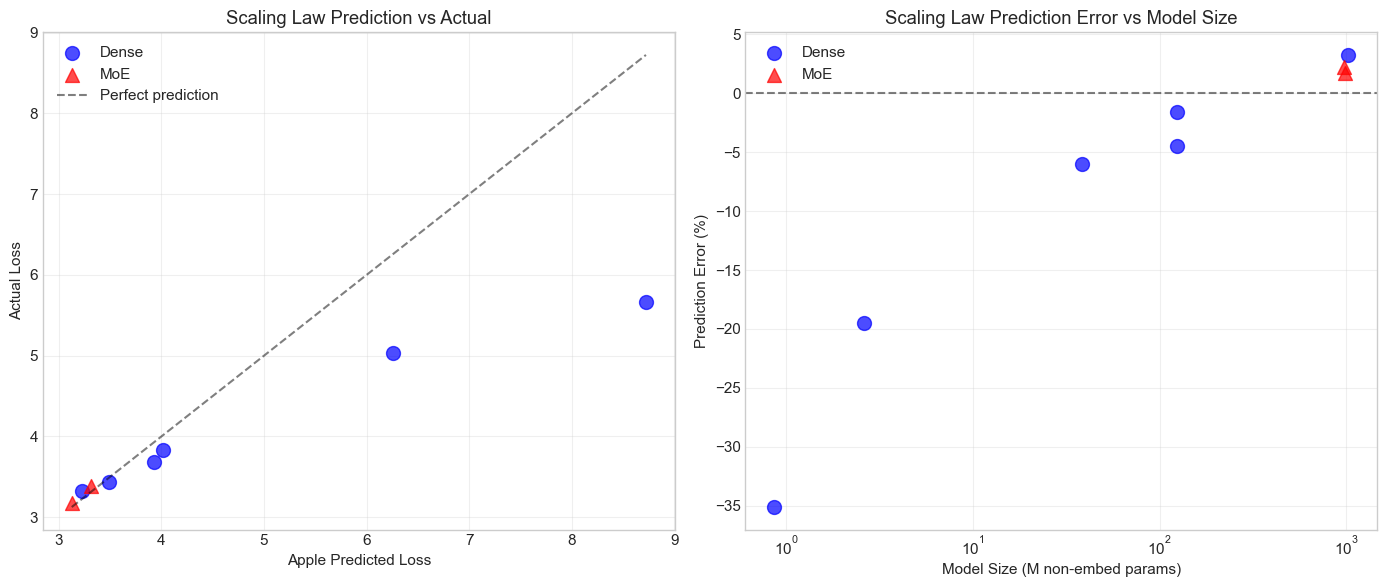

In [8]:
# Visualize: Actual vs Predicted Loss
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Actual vs Predicted (all runs)
ax1 = axes[0]

dense_mask = df_compare['type'] == 'dense'
moe_mask = df_compare['type'] == 'moe'

if dense_mask.any():
    ax1.scatter(df_compare[dense_mask]['Apple Predicted'], 
                df_compare[dense_mask]['Actual Loss'],
                s=100, c='blue', marker='o', label='Dense', alpha=0.7)

if moe_mask.any():
    ax1.scatter(df_compare[moe_mask]['Apple Predicted'], 
                df_compare[moe_mask]['Actual Loss'],
                s=100, c='red', marker='^', label='MoE', alpha=0.7)

# Perfect prediction line
all_vals = list(df_compare['Apple Predicted']) + list(df_compare['Actual Loss'])
min_val, max_val = min(all_vals), max(all_vals)
ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect prediction')

ax1.set_xlabel('Apple Predicted Loss')
ax1.set_ylabel('Actual Loss')
ax1.set_title('Scaling Law Prediction vs Actual')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Prediction Error by Model Size
ax2 = axes[1]

if dense_mask.any():
    ax2.scatter(df_compare[dense_mask]['N (non-embed)'] / 1e6, 
                df_compare[dense_mask]['Apple Error'],
                s=100, c='blue', marker='o', label='Dense', alpha=0.7)

if moe_mask.any():
    ax2.scatter(df_compare[moe_mask]['N (non-embed)'] / 1e6, 
                df_compare[moe_mask]['Apple Error'],
                s=100, c='red', marker='^', label='MoE', alpha=0.7)

ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('Model Size (M non-embed params)')
ax2.set_ylabel('Prediction Error (%)')
ax2.set_title('Scaling Law Prediction Error vs Model Size')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_thurs/scaling_law_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Loss vs Compute Curves

Let's plot the training curves (loss vs tokens/FLOPs) for all models.

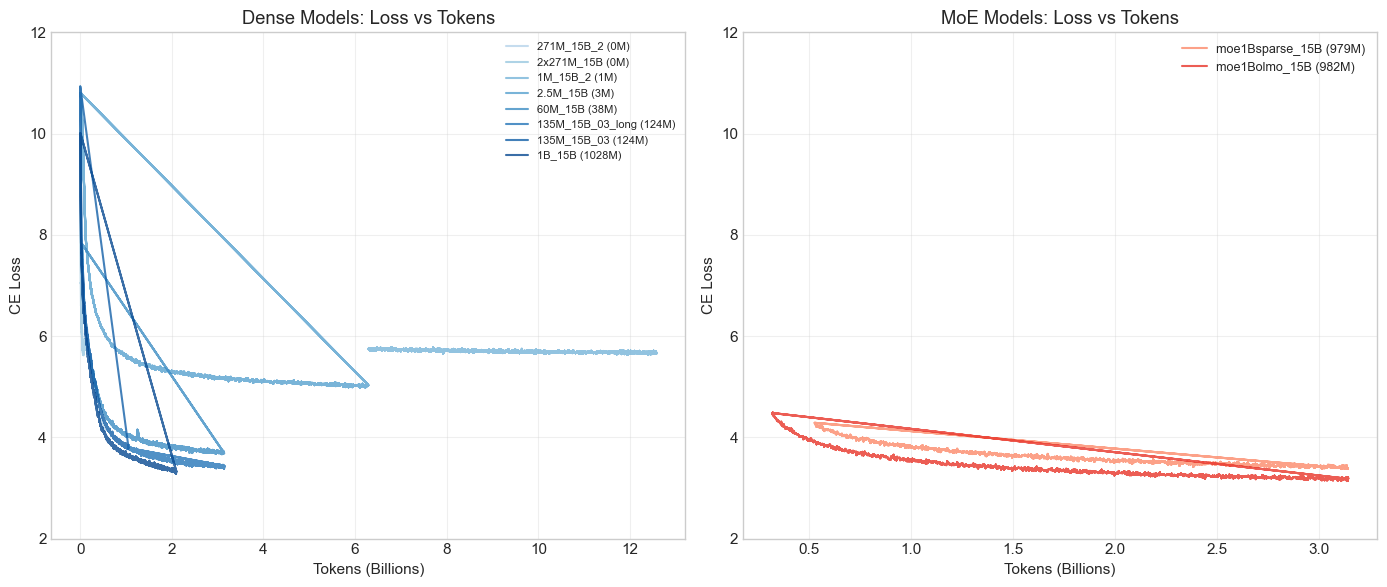

In [9]:
# Plot training curves: Loss vs Tokens
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Define colors for different model sizes
colors_dense = plt.cm.Blues(np.linspace(0.3, 0.9, 8))
colors_moe = plt.cm.Reds(np.linspace(0.4, 0.9, 3))

dense_idx = 0
moe_idx = 0

# Sort by model size for consistent coloring
sorted_names = sorted(detailed_data.keys(), 
                     key=lambda x: detailed_data[x]['info'].get('num_non_embedding_params', 0) or 0)

for name in sorted_names:
    data = detailed_data[name]
    history = data['history']
    info = data['info']
    
    if history.empty or 'throughput/total tokens' not in history.columns:
        continue
    
    # Filter valid data
    mask = history['train/CE loss'].notna() & (history['throughput/total tokens'] > 0)
    h = history[mask]
    
    if len(h) < 10:
        continue
    
    tokens = h['throughput/total tokens'].values / 1e9  # Billions
    loss = h['train/CE loss'].values
    
    N = info.get('num_non_embedding_params', 0) or 0
    label = f"{name.replace('saturate_', '')} ({N/1e6:.0f}M)"
    
    if data['type'] == 'dense':
        color = colors_dense[dense_idx % len(colors_dense)]
        dense_idx += 1
        ax = axes[0]
    else:
        color = colors_moe[moe_idx % len(colors_moe)]
        moe_idx += 1
        ax = axes[1]
    
    ax.plot(tokens, loss, color=color, linewidth=1.5, label=label, alpha=0.8)

axes[0].set_xlabel('Tokens (Billions)')
axes[0].set_ylabel('CE Loss')
axes[0].set_title('Dense Models: Loss vs Tokens')
axes[0].legend(fontsize=8, loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(2, 12)

axes[1].set_xlabel('Tokens (Billions)')
axes[1].set_ylabel('CE Loss')
axes[1].set_title('MoE Models: Loss vs Tokens')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(2, 12)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_thurs/loss_vs_tokens.png', dpi=150, bbox_inches='tight')
plt.show()

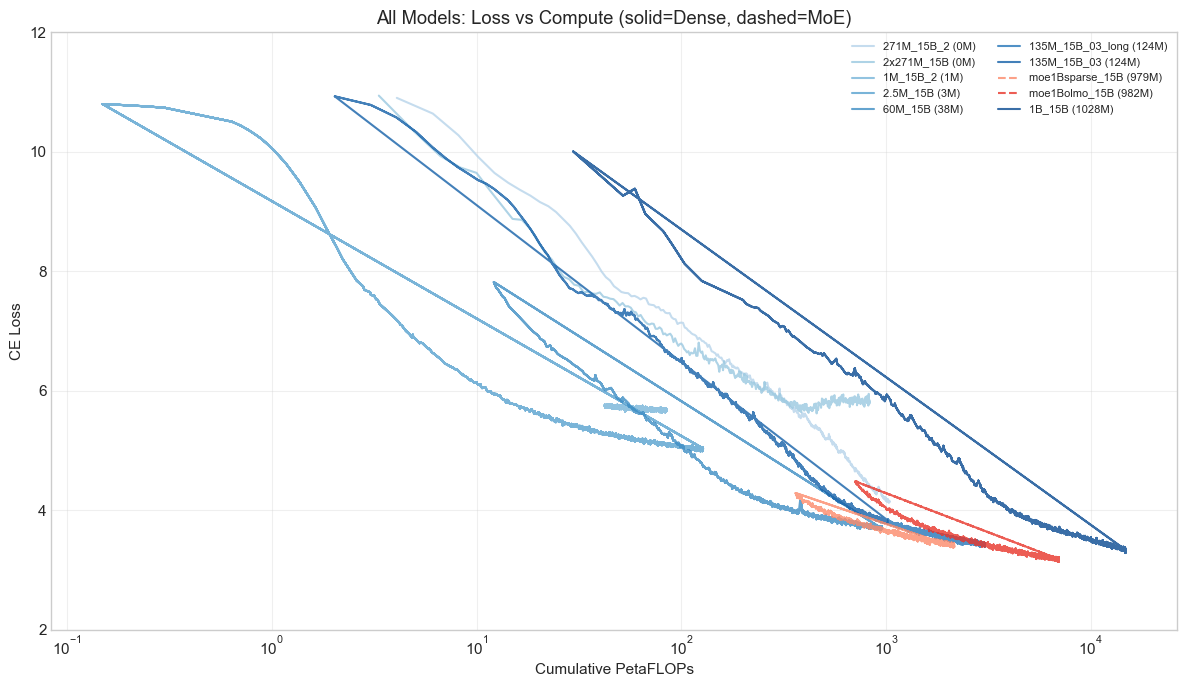

In [10]:
# Plot: Loss vs Compute (PetaFLOPs) - All models on same plot
fig, ax = plt.subplots(figsize=(12, 7))

dense_idx = 0
moe_idx = 0

for name in sorted_names:
    data = detailed_data[name]
    history = data['history']
    info = data['info']
    
    if history.empty or 'throughput/total petaflops' not in history.columns:
        continue
    
    # Filter valid data
    mask = history['train/CE loss'].notna() & (history['throughput/total petaflops'] > 0)
    h = history[mask]
    
    if len(h) < 10:
        continue
    
    pflops = h['throughput/total petaflops'].values
    loss = h['train/CE loss'].values
    
    N = info.get('num_non_embedding_params', 0) or 0
    label = f"{name.replace('saturate_', '')} ({N/1e6:.0f}M)"
    
    if data['type'] == 'dense':
        color = colors_dense[dense_idx % len(colors_dense)]
        dense_idx += 1
        linestyle = '-'
    else:
        color = colors_moe[moe_idx % len(colors_moe)]
        moe_idx += 1
        linestyle = '--'
    
    ax.plot(pflops, loss, color=color, linewidth=1.5, label=label, 
            alpha=0.8, linestyle=linestyle)

ax.set_xlabel('Cumulative PetaFLOPs')
ax.set_ylabel('CE Loss')
ax.set_title('All Models: Loss vs Compute (solid=Dense, dashed=MoE)')
ax.legend(fontsize=8, loc='upper right', ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_ylim(2, 12)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_thurs/loss_vs_pflops.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. MoE vs Dense Efficiency Analysis

Compare MoE and dense models at similar total parameters.

In [11]:
# Compare ~1B models: Dense 1B vs MoE 1B variants
print("\n" + "="*80)
print("COMPARISON: ~1B Parameter Models")
print("="*80)

billion_runs = ['saturate_1B_15B', 'saturate_moe1Bolmo_15B', 'saturate_moe1Bsparse_15B']

for name in billion_runs:
    if name not in detailed_data:
        continue
    
    data = detailed_data[name]
    info = data['info']
    history = data['history']
    
    if history.empty:
        continue
    
    final_row = history.iloc[-1]
    
    print(f"\n{name}:")
    print(f"  Type: {'MoE' if info['is_moe'] else 'Dense'}")
    print(f"  Total params: {info['num_params']/1e9:.3f}B")
    print(f"  Non-embed params: {info['num_non_embedding_params']/1e9:.3f}B")
    
    if info['is_moe']:
        print(f"  Active non-embed: {info['active_non_embed_params']/1e6:.1f}M")
        print(f"  Sparsity: {info['sparsity']:.1%}")
        print(f"  Experts: {info['num_experts']}, top_k={info['top_k']}")
    
    print(f"  Total tokens: {final_row.get('throughput/total tokens', 0)/1e9:.2f}B")
    print(f"  Total PetaFLOPs: {final_row.get('throughput/total petaflops', 0):,.0f}")
    print(f"  Final loss: {final_row.get('train/CE loss', 'N/A'):.4f}")


COMPARISON: ~1B Parameter Models

saturate_1B_15B:
  Type: Dense
  Total params: 1.131B
  Non-embed params: 1.028B
  Total tokens: 2.10B
  Total PetaFLOPs: 14,834
  Final loss: 3.3307

saturate_moe1Bolmo_15B:
  Type: MoE
  Total params: 1.040B
  Non-embed params: 0.982B
  Active non-embed: 255.2M
  Sparsity: 74.0%
  Experts: 32, top_k=4
  Total tokens: 3.14B
  Total PetaFLOPs: 6,978
  Final loss: 3.1796

saturate_moe1Bsparse_15B:
  Type: MoE
  Total params: 1.017B
  Non-embed params: 0.979B
  Active non-embed: 37.7M
  Sparsity: 96.1%
  Experts: 256, top_k=1
  Total tokens: 3.14B
  Total PetaFLOPs: 2,152
  Final loss: 3.3821


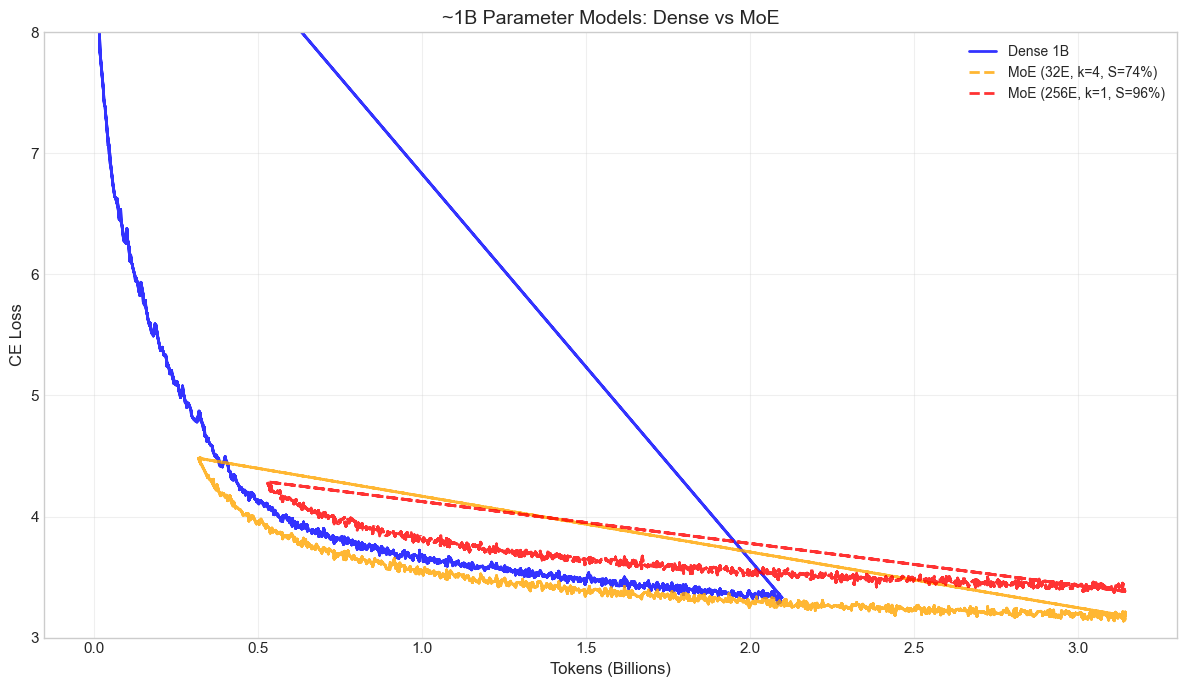

In [12]:
# Plot: Loss curves for ~1B models side by side
fig, ax = plt.subplots(figsize=(12, 7))

for name in billion_runs:
    if name not in detailed_data:
        continue
    
    data = detailed_data[name]
    history = data['history']
    info = data['info']
    
    if history.empty or 'throughput/total tokens' not in history.columns:
        continue
    
    mask = history['train/CE loss'].notna() & (history['throughput/total tokens'] > 0)
    h = history[mask]
    
    tokens = h['throughput/total tokens'].values / 1e9
    loss = h['train/CE loss'].values
    
    if info['is_moe']:
        style = '--'
        color = 'red' if 'sparse' in name else 'orange'
        label = f"MoE ({info['num_experts']}E, k={info['top_k']}, S={info['sparsity']:.0%})"
    else:
        style = '-'
        color = 'blue'
        label = f"Dense 1B"
    
    ax.plot(tokens, loss, linestyle=style, color=color, linewidth=2, label=label, alpha=0.8)

ax.set_xlabel('Tokens (Billions)', fontsize=12)
ax.set_ylabel('CE Loss', fontsize=12)
ax.set_title('~1B Parameter Models: Dense vs MoE', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(3, 8)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_thurs/1B_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Compute Efficiency Analysis

Quantify how much more efficient MoE is compared to dense models.

In [13]:
def interpolate_loss_at_pflops(history: pd.DataFrame, target_pflops: float) -> Optional[float]:
    """Interpolate loss at a specific PetaFLOPs value."""
    if 'throughput/total petaflops' not in history.columns:
        return None
    
    mask = history['train/CE loss'].notna() & (history['throughput/total petaflops'] > 0)
    h = history[mask].copy()
    
    if len(h) < 2:
        return None
    
    pflops = h['throughput/total petaflops'].values
    loss = h['train/CE loss'].values
    
    if target_pflops < pflops.min() or target_pflops > pflops.max():
        return None
    
    return np.interp(target_pflops, pflops, loss)


def find_pflops_for_loss(history: pd.DataFrame, target_loss: float) -> Optional[float]:
    """Find PetaFLOPs needed to reach a target loss."""
    if 'throughput/total petaflops' not in history.columns:
        return None
    
    mask = history['train/CE loss'].notna() & (history['throughput/total petaflops'] > 0)
    h = history[mask].copy()
    
    if len(h) < 2:
        return None
    
    pflops = h['throughput/total petaflops'].values
    loss = h['train/CE loss'].values
    
    if target_loss < loss.min() or target_loss > loss.max():
        return None
    
    # Loss is decreasing, so we need to flip for interpolation
    idx_sorted = np.argsort(loss)[::-1]  # Sort by decreasing loss
    return np.interp(target_loss, loss[idx_sorted], pflops[idx_sorted])


# Compare efficiency at same loss target
print("\n" + "="*80)
print("COMPUTE EFFICIENCY: PetaFLOPs to reach target loss")
print("="*80)

target_losses = [4.0, 3.5, 3.3]

efficiency_data = []

for target_loss in target_losses:
    print(f"\nTarget Loss = {target_loss}:")
    
    for name in billion_runs:
        if name not in detailed_data:
            continue
        
        data = detailed_data[name]
        history = data['history']
        info = data['info']
        
        pflops_needed = find_pflops_for_loss(history, target_loss)
        
        if pflops_needed:
            print(f"  {name}: {pflops_needed:,.0f} PetaFLOPs")
            efficiency_data.append({
                'target_loss': target_loss,
                'name': name,
                'type': 'MoE' if info['is_moe'] else 'Dense',
                'pflops': pflops_needed
            })
        else:
            print(f"  {name}: Did not reach this loss")


COMPUTE EFFICIENCY: PetaFLOPs to reach target loss

Target Loss = 4.0:
  saturate_1B_15B: 14,752 PetaFLOPs
  saturate_moe1Bolmo_15B: 6,964 PetaFLOPs
  saturate_moe1Bsparse_15B: 2,130 PetaFLOPs

Target Loss = 3.5:
  saturate_1B_15B: 14,752 PetaFLOPs
  saturate_moe1Bolmo_15B: 6,964 PetaFLOPs
  saturate_moe1Bsparse_15B: 2,130 PetaFLOPs

Target Loss = 3.3:
  saturate_1B_15B: 14,752 PetaFLOPs
  saturate_moe1Bolmo_15B: 6,964 PetaFLOPs
  saturate_moe1Bsparse_15B: Did not reach this loss


In [14]:
# Calculate efficiency multiplier
if efficiency_data:
    df_eff = pd.DataFrame(efficiency_data)
    
    print("\n" + "="*80)
    print("MoE EFFICIENCY MULTIPLIER (vs Dense 1B)")
    print("="*80)
    
    for target_loss in target_losses:
        subset = df_eff[df_eff['target_loss'] == target_loss]
        
        dense_pflops = subset[subset['type'] == 'Dense']['pflops'].values
        if len(dense_pflops) == 0:
            continue
        dense_pflops = dense_pflops[0]
        
        print(f"\nTarget Loss = {target_loss}:")
        print(f"  Dense 1B: {dense_pflops:,.0f} PetaFLOPs")
        
        for _, row in subset[subset['type'] == 'MoE'].iterrows():
            multiplier = dense_pflops / row['pflops']
            savings = (1 - row['pflops'] / dense_pflops) * 100
            print(f"  {row['name'].replace('saturate_', '')}: {row['pflops']:,.0f} PetaFLOPs")
            print(f"    → {multiplier:.2f}x more efficient ({savings:.1f}% compute savings)")


MoE EFFICIENCY MULTIPLIER (vs Dense 1B)

Target Loss = 4.0:
  Dense 1B: 14,752 PetaFLOPs
  moe1Bolmo_15B: 6,964 PetaFLOPs
    → 2.12x more efficient (52.8% compute savings)
  moe1Bsparse_15B: 2,130 PetaFLOPs
    → 6.93x more efficient (85.6% compute savings)

Target Loss = 3.5:
  Dense 1B: 14,752 PetaFLOPs
  moe1Bolmo_15B: 6,964 PetaFLOPs
    → 2.12x more efficient (52.8% compute savings)
  moe1Bsparse_15B: 2,130 PetaFLOPs
    → 6.93x more efficient (85.6% compute savings)

Target Loss = 3.3:
  Dense 1B: 14,752 PetaFLOPs
  moe1Bolmo_15B: 6,964 PetaFLOPs
    → 2.12x more efficient (52.8% compute savings)


## 8. Scaling Law Fit Quality

Let's examine how well the Apple scaling law fits our data across all model sizes.

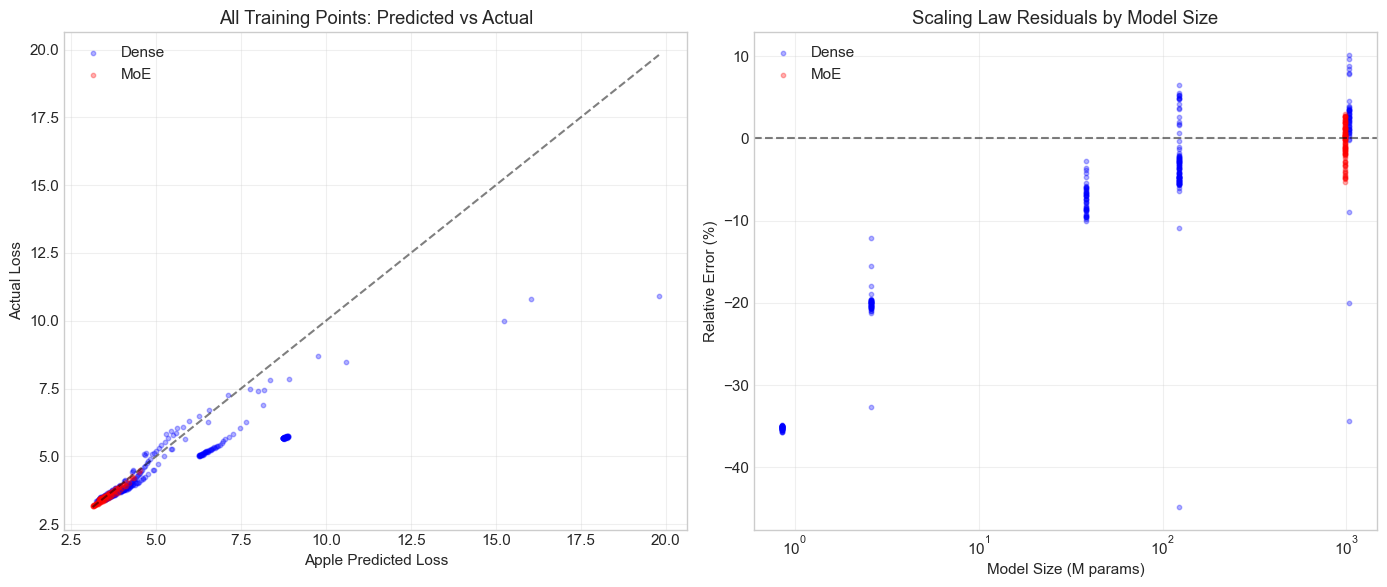


Scaling Law Fit Statistics:
  Total prediction points: 407
  Mean relative error: -8.41%
  Std relative error: 12.48%
  RMSE: 1.3264


In [15]:
# Create a comprehensive scatter plot: Predicted vs Actual for training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Collect all (predicted, actual) pairs from training histories
all_predictions = []

for name, data in detailed_data.items():
    info = data['info']
    history = data['history']
    
    if history.empty or 'throughput/total tokens' not in history.columns:
        continue
    
    N = info['num_non_embedding_params']
    S = info['sparsity'] if info['sparsity'] is not None else 0.0
    
    if N is None:
        continue
    
    # Sample points along the training curve
    mask = history['train/CE loss'].notna() & (history['throughput/total tokens'] > 0)
    h = history[mask]
    
    # Sample every 100 steps
    for idx in range(0, len(h), max(1, len(h) // 50)):
        row = h.iloc[idx]
        D = row['throughput/total tokens']
        actual = row['train/CE loss']
        
        if D > 0:
            predicted = apple_moe_loss(N, D, S)
            all_predictions.append({
                'name': name,
                'type': data['type'],
                'N': N,
                'D': D,
                'S': S,
                'predicted': predicted,
                'actual': actual
            })

df_pred = pd.DataFrame(all_predictions)

# Plot 1: All predictions
ax1 = axes[0]
dense_mask = df_pred['type'] == 'dense'
moe_mask = df_pred['type'] == 'moe'

ax1.scatter(df_pred[dense_mask]['predicted'], df_pred[dense_mask]['actual'],
            s=10, alpha=0.3, c='blue', label='Dense')
ax1.scatter(df_pred[moe_mask]['predicted'], df_pred[moe_mask]['actual'],
            s=10, alpha=0.3, c='red', label='MoE')

# Perfect prediction line
min_val = min(df_pred['predicted'].min(), df_pred['actual'].min())
max_val = max(df_pred['predicted'].max(), df_pred['actual'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

ax1.set_xlabel('Apple Predicted Loss')
ax1.set_ylabel('Actual Loss')
ax1.set_title('All Training Points: Predicted vs Actual')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals by model size
ax2 = axes[1]
df_pred['residual'] = df_pred['actual'] - df_pred['predicted']
df_pred['relative_error'] = df_pred['residual'] / df_pred['predicted'] * 100

ax2.scatter(df_pred[dense_mask]['N'] / 1e6, df_pred[dense_mask]['relative_error'],
            s=10, alpha=0.3, c='blue', label='Dense')
ax2.scatter(df_pred[moe_mask]['N'] / 1e6, df_pred[moe_mask]['relative_error'],
            s=10, alpha=0.3, c='red', label='MoE')

ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('Model Size (M params)')
ax2.set_ylabel('Relative Error (%)')
ax2.set_title('Scaling Law Residuals by Model Size')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_thurs/scaling_law_fit.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nScaling Law Fit Statistics:")
print(f"  Total prediction points: {len(df_pred)}")
print(f"  Mean relative error: {df_pred['relative_error'].mean():.2f}%")
print(f"  Std relative error: {df_pred['relative_error'].std():.2f}%")
print(f"  RMSE: {np.sqrt((df_pred['residual']**2).mean()):.4f}")

## 9. Summary and Conclusions

In [16]:
print("\n" + "="*80)
print("SUMMARY: Scaling Law Analysis")
print("="*80)

print("\n1. EXPERIMENTAL RUNS ANALYZED:")
print(f"   - Dense models: {len([d for d in detailed_data.values() if d['type'] == 'dense'])}")
print(f"   - MoE models: {len([d for d in detailed_data.values() if d['type'] == 'moe'])}")

print("\n2. SCALING LAW FIT:")
print(f"   - Apple MoE law mean relative error: {df_pred['relative_error'].mean():.1f}%")
print(f"   - Error std: {df_pred['relative_error'].std():.1f}%")

print("\n3. KEY FINDINGS:")

# Find best performing models
best_dense = None
best_moe = None
best_dense_loss = float('inf')
best_moe_loss = float('inf')

for name, data in detailed_data.items():
    info = data['info']
    if info['final_loss'] is None:
        continue
    
    if data['type'] == 'dense' and info['final_loss'] < best_dense_loss:
        best_dense_loss = info['final_loss']
        best_dense = name
    elif data['type'] == 'moe' and info['final_loss'] < best_moe_loss:
        best_moe_loss = info['final_loss']
        best_moe = name

if best_dense:
    print(f"   - Best dense model: {best_dense} (loss={best_dense_loss:.4f})")
if best_moe:
    print(f"   - Best MoE model: {best_moe} (loss={best_moe_loss:.4f})")

print("\n4. MoE EFFICIENCY:")
if 'saturate_moe1Bolmo_15B' in detailed_data and 'saturate_1B_15B' in detailed_data:
    moe_info = detailed_data['saturate_moe1Bolmo_15B']['info']
    dense_info = detailed_data['saturate_1B_15B']['info']
    
    print(f"   At ~1B params:")
    print(f"   - Dense 1B final loss: {dense_info['final_loss']:.4f}")
    print(f"   - MoE 1B (OLMo-style) final loss: {moe_info['final_loss']:.4f}")
    print(f"   - MoE sparsity: {moe_info['sparsity']:.1%}")
    print(f"   - MoE achieves {(dense_info['final_loss'] - moe_info['final_loss'])/dense_info['final_loss']*100:.1f}% lower loss")

print("\n" + "="*80)


SUMMARY: Scaling Law Analysis

1. EXPERIMENTAL RUNS ANALYZED:
   - Dense models: 8
   - MoE models: 2

2. SCALING LAW FIT:
   - Apple MoE law mean relative error: -8.4%
   - Error std: 12.5%

3. KEY FINDINGS:
   - Best dense model: saturate_1B_15B (loss=3.3307)
   - Best MoE model: saturate_moe1Bolmo_15B (loss=3.1801)

4. MoE EFFICIENCY:
   At ~1B params:
   - Dense 1B final loss: 3.3307
   - MoE 1B (OLMo-style) final loss: 3.1801
   - MoE sparsity: 74.0%
   - MoE achieves 4.5% lower loss



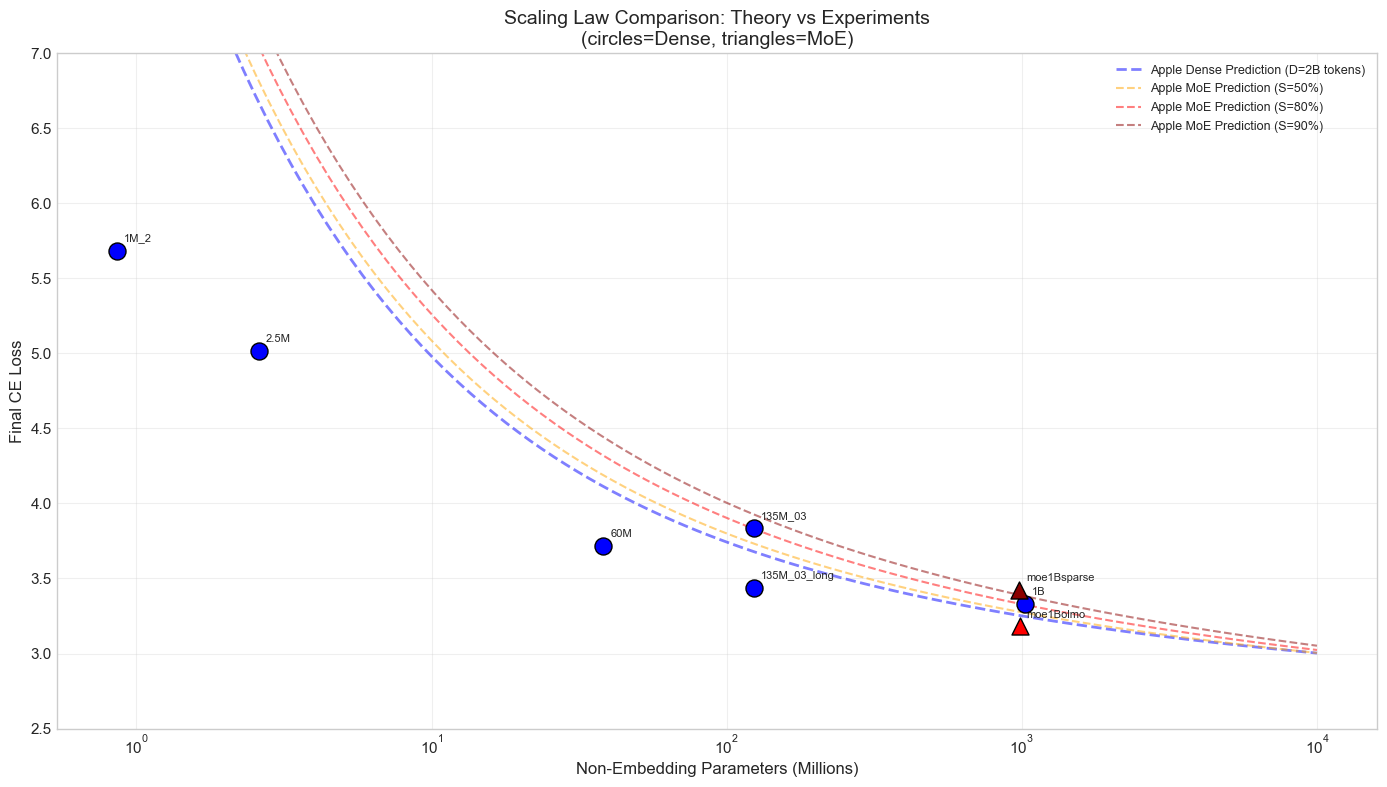


All visualizations saved to /Users/timur/Desktop/Relace/wandb_thurs/


In [17]:
# Final visualization: All results on one plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot theoretical scaling laws
N_range = np.logspace(6, 10, 100)  # 1M to 10B params
D_fixed = 2e9  # 2B tokens (approximately what our runs used)

# Apple dense prediction
dense_pred = [apple_dense_loss(N, D_fixed) for N in N_range]
ax.plot(N_range / 1e6, dense_pred, 'b--', linewidth=2, alpha=0.5, 
        label='Apple Dense Prediction (D=2B tokens)')

# Apple MoE predictions at different sparsities
for S, color in [(0.5, 'orange'), (0.8, 'red'), (0.9, 'darkred')]:
    moe_pred = [apple_moe_loss(N, D_fixed, S) for N in N_range]
    ax.plot(N_range / 1e6, moe_pred, color=color, linestyle='--', linewidth=1.5, alpha=0.5,
            label=f'Apple MoE Prediction (S={S:.0%})')

# Plot actual experimental results
for name, data in detailed_data.items():
    info = data['info']
    
    N = info.get('num_non_embedding_params')
    loss = info.get('final_loss')
    
    if N is None or loss is None:
        continue
    
    if data['type'] == 'dense':
        marker = 'o'
        color = 'blue'
    else:
        marker = '^'
        S = info.get('sparsity', 0)
        if S > 0.8:
            color = 'darkred'
        else:
            color = 'red'
    
    label = name.replace('saturate_', '').replace('_15B', '')
    ax.scatter([N / 1e6], [loss], s=150, marker=marker, c=color, 
               edgecolors='black', linewidths=1, zorder=10)
    ax.annotate(label, (N / 1e6, loss), fontsize=8, ha='left', va='bottom',
                xytext=(5, 5), textcoords='offset points')

ax.set_xlabel('Non-Embedding Parameters (Millions)', fontsize=12)
ax.set_ylabel('Final CE Loss', fontsize=12)
ax.set_title('Scaling Law Comparison: Theory vs Experiments\n(circles=Dense, triangles=MoE)', fontsize=14)
ax.set_xscale('log')
ax.set_ylim(2.5, 7)
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_thurs/final_scaling_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAll visualizations saved to /Users/timur/Desktop/Relace/wandb_thurs/")